MEDIAPIPE


In [13]:
import cv2
import numpy as np
import mediapipe as mp
from matplotlib import pyplot as plt

In [34]:
# Initialize MediaPipe Hands.
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

In [69]:
def detect_hand_landmarks(image):
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect hand landmarks.
    results = hands.process(image_rgb)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    landmarks = []

    
    if results.multi_hand_landmarks:
        # for i in range(21):
            # Display the found landmarks after converting them into their original scale.
            # print(f'{mp_hands.HandLandmark(i).name}:') 
            # print(f'x: {results.multi_hand_landmarks[0].landmark[mp_hands.HandLandmark(i).value].x }')
            # print(f'y: {results.multi_hand_landmarks[0].landmark[mp_hands.HandLandmark(i).value].y }')
            # print(f'z: {results.multi_hand_landmarks[0].landmark[mp_hands.HandLandmark(i).value].z }')

        # Draw landmarks on the image.
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        #isko change unnecessarily values convert kr rhe
        for landmark in results.multi_hand_landmarks[0].landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height)))

    # Show the output image.
    plt.figure(figsize=[4,4])
    plt.imshow(image[:,:,::-1]);plt.title("Mediapipe Landmarks");plt.axis('off');
    plt.show()
    
    return landmarks

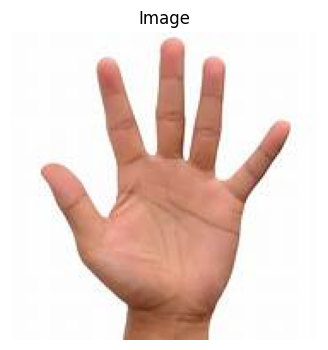

In [70]:
# Read the input image.
image_path='images/img.jpeg'
image = cv2.imread(image_path)
# cv2.imshow('Window', img)
# cv2.waitKey(0)
plt.figure(figsize=[4,4])
plt.imshow(image[:,:,::-1]);plt.title("Image");plt.axis('off');
plt.show()

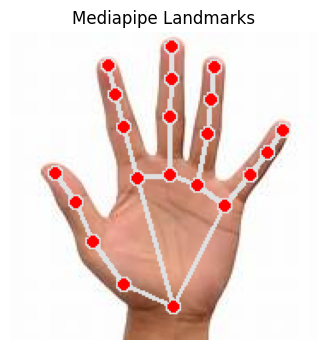

In [71]:
landmarks =detect_hand_landmarks(image)

OPENPOSE

In [29]:
protoFile = "hand/pose_deploy.prototxt"
#download manually or contact me for the file.
weightsFile = "hand/pose_iter_102000.caffemodel"
nPoints = 22
POSE_PAIRS = [ [0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20] ]
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


In [73]:
def detect_landmarks(image_path):
    frame = cv2.imread(image_path)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    aspect_ratio = frameWidth/frameHeight

    threshold = 0.08

    # input image dimensions for the network
    inHeight = 180
    inWidth = int(((aspect_ratio*inHeight)*8)//8)
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)

    output = net.forward()
    # print("time taken by network : {:.3f}".format(time.time() - t))


    points = []
    index=[]

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))
    
        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
        if prob > threshold :
            cv2.circle(frameCopy, (int(point[0]), int(point[1])), 4, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            # cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
    
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(point[0]), int(point[1])))
            index.append(i)
        else :
            points.append(None)
    
    
    plt.figure(figsize=[4,4])
    plt.imshow(frameCopy[:,:,::-1]);plt.title("OpenPose Landmarks");plt.axis('off')
    plt.show()

    return points, index

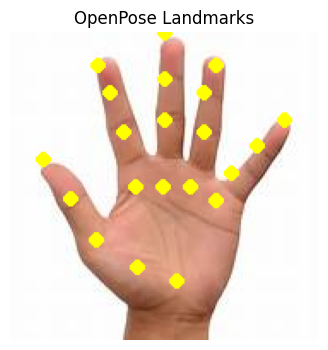

In [74]:
image_path="images/img.jpeg"
points,index=detect_landmarks(image_path)

VISUALIZATION

In [53]:
import json

# Load the JSON file
json_path = 'TruthValues/actual_points.json'
with open(json_path) as f:
    data = json.load(f)

# Extract landmarks
actual_points = []
for image_key, image_data in data.items():
    for region in image_data['regions']:
        shape_attributes = region['shape_attributes']
        if shape_attributes['name'] == 'point':
            cx = shape_attributes['cx']
            cy = shape_attributes['cy']
            actual_points.append((cx, cy))

# Print the extracted landmarks
print(actual_points)


[(96, 161), (61, 147), (52, 121), (38, 100), (21, 80), (76, 82), (67, 55), (61, 35), (55, 17), (95, 81), (95, 52), (95, 27), (96, 6), (110, 88), (116, 58), (119, 39), (119, 16), (127, 99), (142, 83), (151, 70), (162, 55)]


In [54]:
print("Ground Truth")
print(actual_points)
print("MediaPipe")
print(landmarks)
print("Openpose")
newPoints=[]
newPoints = [point for point in points if point is not None]
print(newPoints)

ap_for_op=[]
for i in index:
    ap_for_op.append(actual_points[i])

Ground Truth
[(96, 161), (61, 147), (52, 121), (38, 100), (21, 80), (76, 82), (67, 55), (61, 35), (55, 17), (95, 81), (95, 52), (95, 27), (96, 6), (110, 88), (116, 58), (119, 39), (119, 16), (127, 99), (142, 83), (151, 70), (162, 55)]
MediaPipe
[(95, 160), (66, 147), (48, 122), (38, 99), (26, 82), (74, 85), (66, 55), (61, 36), (57, 19), (93, 83), (93, 49), (94, 27), (94, 8), (109, 89), (115, 59), (117, 39), (119, 20), (125, 101), (140, 83), (150, 70), (159, 57)]
Openpose
[(97, 145), (74, 137), (50, 121), (35, 97), (19, 74), (73, 90), (66, 58), (58, 35), (51, 19), (89, 90), (90, 51), (90, 27), (90, 0), (105, 90), (113, 58), (113, 35), (120, 19), (120, 98), (129, 82), (144, 66), (160, 51)]


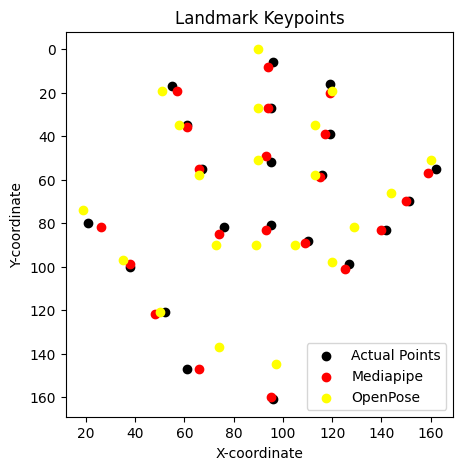

In [55]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

# Dictionary to keep track of labels already associated with each color
color_labels = {}

# Plot actual points
for keypoint in actual_points:
    x, y = keypoint
    plt.scatter(x, y, color='black', label='Actual Points' if 'black' not in color_labels else '')
    color_labels['black'] = 'Actual Points'

# Plot Mediapipe landmarks
for keypoint in landmarks:
    x, y = keypoint
    plt.scatter(x, y, color='red', label='Mediapipe' if 'red' not in color_labels else '')
    color_labels['red'] = 'Mediapipe'

# Plot OpenPose points
for keypoint in newPoints:
    x, y = keypoint
    plt.scatter(x, y, color='yellow', label='OpenPose' if 'yellow' not in color_labels else '')
    color_labels['yellow'] = 'OpenPose'

plt.gca().invert_yaxis()
plt.title('Landmark Keypoints')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

plt.legend()

plt.show()


In [80]:
import pandas as pd

# Sample x, y coordinates
coordinates_set1 = [(10, 20), (30, 40), (50, 60)]
coordinates_set2 = [(15, 25), (35, 45), (55, 65)]
coordinates_set3 = [(12, 22), (32, 42), (52, 62)]

# Create DataFrames for each set of coordinates
df_set1 = pd.DataFrame(actual_points, columns=['X', 'Y'])
df_set2 = pd.DataFrame(landmarks, columns=['X', 'Y'])
df_set3 = pd.DataFrame(newPoints, columns=['X', 'Y'])


# Concatenate DataFrames horizontally
df_combined = pd.concat([df_set1, df_set2, df_set3], axis=1)

# Set display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Print the combined DataFrame with borders
print(df_combined.to_string(index=False, justify='center', col_space=8))


    X        Y        X        Y        X        Y   
   96      161       95      160       97      145   
   61      147       66      147       74      137   
   52      121       48      122       50      121   
   38      100       38       99       35       97   
   21       80       26       82       19       74   
   76       82       74       85       73       90   
   67       55       66       55       66       58   
   61       35       61       36       58       35   
   55       17       57       19       51       19   
   95       81       93       83       89       90   
   95       52       93       49       90       51   
   95       27       94       27       90       27   
   96        6       94        8       90        0   
  110       88      109       89      105       90   
  116       58      115       59      113       58   
  119       39      117       39      113       35   
  119       16      119       20      120       19   
  127       99      125     

In [81]:
import numpy as np

def calculate_rmse(true_coordinates, predicted_coordinates):
    # Convert lists of tuples to numpy arrays for easier computation
    true_coordinates = np.array(true_coordinates)
    predicted_coordinates = np.array(predicted_coordinates)
    
    # Calculate squared differences
    squared_diff = np.square(true_coordinates - predicted_coordinates)
    
    # Calculate mean squared error
    mse = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    return rmse

rmse1 = calculate_rmse(actual_points, landmarks)
print("RMSE Mediapipe:", rmse1)

rmse2 = calculate_rmse(ap_for_op, newPoints)
print("RMSE OpenPose:", rmse2)



RMSE Mediapipe: 2.052872551885702
RMSE OpenPose: 5.6589583426465975


In [58]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

actual= np.array(actual_points)
landmark_arr=np.array(landmarks)
# euclidean_distance(actual, landmark_arr)

mean_distance1 = np.mean(euclidean_distance(actual, landmark_arr))
print("Euclidian Distance Mediapipe: ",mean_distance1)


actual= np.array(ap_for_op)
landmark_arr=np.array(newPoints)
# euclidean_distance(actual, landmark_arr)

mean_distance2 = np.mean(euclidean_distance(actual, landmark_arr))
print("Euclidian Distance OpenPose: ",mean_distance2)

Euclidian Distance Mediapipe:  3.0495097567963922
Euclidian Distance OpenPose:  15.953183537259253


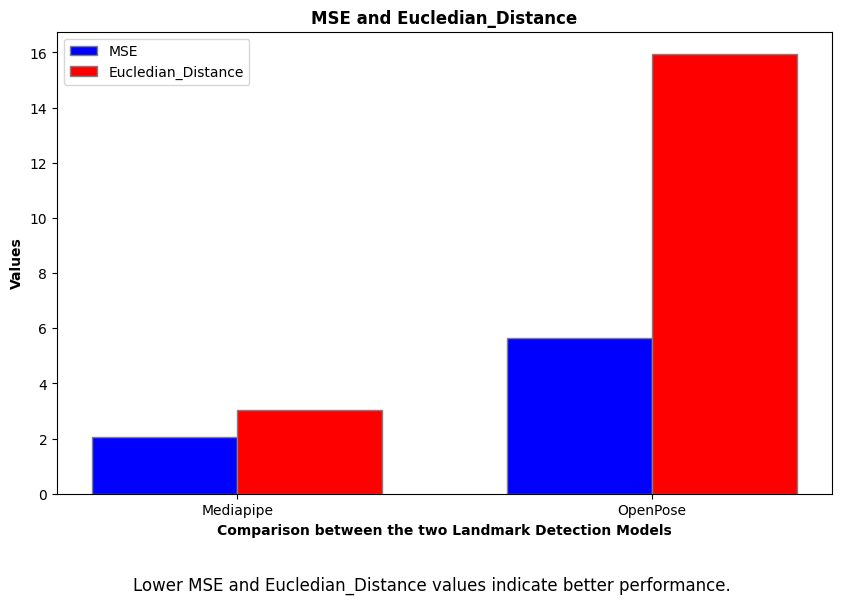

In [82]:
# Prepare data for plotting
methods = ['Mediapipe', 'OpenPose']
mse_values = [rmse1, rmse2]
accuracy_values = [mean_distance1, mean_distance2]

# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set width of bar
bar_width = 0.35

# Set positions of bars on X axis
r1 = np.arange(len(methods))
r2 = [x + bar_width for x in r1]

# Make the plot
ax1.bar(r1, mse_values, color='b', width=bar_width, edgecolor='grey', label='MSE')
ax1.bar(r2, accuracy_values, color='r', width=bar_width, edgecolor='grey', label='Eucledian_Distance')

# Add labels
ax1.set_xlabel('Comparison between the two Landmark Detection Models', fontweight='bold')
ax1.set_ylabel('Values', fontweight='bold')
ax1.set_title('MSE and Eucledian_Distance', fontweight='bold')
ax1.set_xticks([r + bar_width / 2 for r in range(len(methods))])
ax1.set_xticklabels(methods)
ax1.legend()

# Adding a note
plt.figtext(0.5, -0.05, 'Lower MSE and Eucledian_Distance values indicate better performance.', wrap=True, horizontalalignment='center', fontsize=12)

# Show the plot
plt.show()

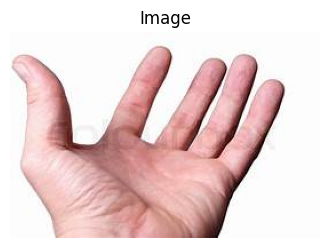

In [84]:
# Read the input image.
image_path='images/hp.jpeg'
image = cv2.imread(image_path)
# cv2.imshow('Window', img)
# cv2.waitKey(0)
plt.figure(figsize=[4,4])
plt.imshow(image[:,:,::-1]);plt.title("Image");plt.axis('off');
plt.show()

C:\Users\ishan\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


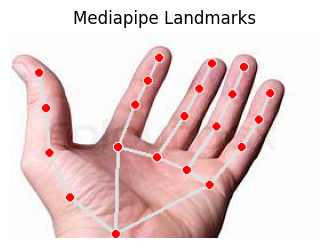

In [85]:
landmarks =detect_hand_landmarks(image)

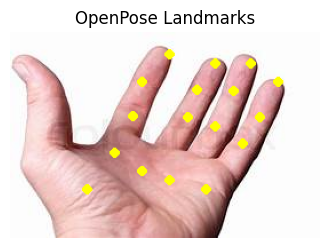

In [86]:
image_path="images/hp.jpeg"
points,index=detect_landmarks(image_path)

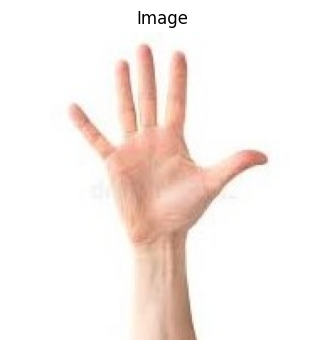

In [104]:
# Read the input image.
image_path='images/han.jpg'
image = cv2.imread(image_path)
# cv2.imshow('Window', img)
# cv2.waitKey(0)
plt.figure(figsize=[4,4])
plt.imshow(image[:,:,::-1]);plt.title("Image");plt.axis('off');
plt.show()

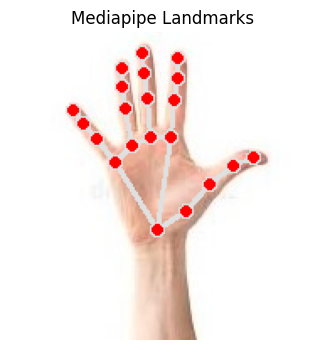

In [105]:
landmarks =detect_hand_landmarks(image)

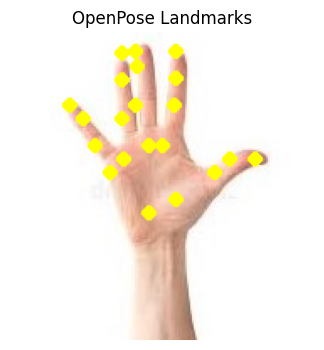

In [106]:
image_path="images/han.jpg"
points,index=detect_landmarks(image_path)